# Dependency

In [1]:
import h5py
import os
import pickle
from tqdm import tqdm
from time import gmtime, strftime
import numpy as np
import math
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers,Model
from sklearn.model_selection import KFold
import gc
import time
from sklearn.model_selection import KFold
import import_test as data_load

# PARAM

In [2]:
MAX_SEQ_LENGTH= 1100
#NUM_FEATURE = 1024
NUM_FEATURE = 1024 # esm1 & 2 a
NUM_FILTER = 64
NUM_HIDDEN = 512#100
BATCH_SIZE  = 32
WINDOW_SIZES = [4, 8, 16]
NUM_CLASSES = 2
CLASS_NAMES = ['1','0']
EPOCHS      =25
K_Fold = 5
VALIDATION_MODE="independent" # cross or independent
class_names = ["Sodium", "Membrane"]

# Data Loader Function

In [9]:
"----------------------------------------------------------------------------------------------------"
# model fit batch funtion
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, labels, batch_size):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.data))
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = [self.data[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]
        return np.array(batch_data), np.array(batch_labels)
    
"----------------------------------------------------------------------------------------------------"

'----------------------------------------------------------------------------------------------------'

In [4]:
write_data=[]
write_data.append(NUM_FEATURE)
write_data.append(BATCH_SIZE)
write_data.append(NUM_HIDDEN)
write_data.append(WINDOW_SIZES)
write_data.append(NUM_FILTER)
write_data.append(VALIDATION_MODE)

## MCNN model

In [5]:
class DeepScan(Model):

	def __init__(self,
	             input_shape=(1, MAX_SEQ_LENGTH, NUM_FEATURE),
	             window_sizes=WINDOW_SIZES,
	             num_filters=NUM_FILTER,
	             num_hidden=NUM_HIDDEN):
		super(DeepScan, self).__init__()
		# Add input layer
		self.input_layer = tf.keras.Input(input_shape)
		self.window_sizes = window_sizes
		self.conv2d = []
		self.maxpool = []
		self.flatten = []
		for window_size in self.window_sizes:
			self.conv2d.append(
			 layers.Conv2D(filters=num_filters,
			               kernel_size=(1, window_size),
			               activation=tf.nn.relu,
			               padding='valid',
			               bias_initializer=tf.constant_initializer(0.1),
			               kernel_initializer=tf.keras.initializers.GlorotUniform()))
			self.maxpool.append(
			 layers.MaxPooling2D(pool_size=(1, MAX_SEQ_LENGTH - window_size + 1),
			                     strides=(1, MAX_SEQ_LENGTH),
			                     padding='valid'))
			self.flatten.append(layers.Flatten())
		self.dropout = layers.Dropout(rate=0.7)
		self.fc1 = layers.Dense(
		 num_hidden,
		 activation=tf.nn.relu,
		 bias_initializer=tf.constant_initializer(0.1),
		 kernel_initializer=tf.keras.initializers.GlorotUniform())
		self.fc2 = layers.Dense(NUM_CLASSES,
		                        activation='softmax',
		                        kernel_regularizer=tf.keras.regularizers.l2(1e-3))

		# Get output layer with `call` method
		self.out = self.call(self.input_layer)

	def call(self, x, training=False):
		_x = []
		for i in range(len(self.window_sizes)):
			x_conv = self.conv2d[i](x)
			x_maxp = self.maxpool[i](x_conv)
			x_flat = self.flatten[i](x_maxp)
			_x.append(x_flat)

		x = tf.concat(_x, 1)
		x = self.dropout(x, training=training)
		x = self.fc1(x)
		x = self.fc2(x)  #Best Threshold
		return x

In [6]:
def model_test(model, x_test, y_test, classifier_name='mCNN'):
    print(x_test.shape)
    pred_test = model.predict(x_test)
    fpr, tpr, thresholds = roc_curve(y_test[:, 1], pred_test[:, 1])
    AUC = metrics.auc(fpr, tpr)

    # Display ROC curve
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=AUC, estimator_name=classifier_name)
    display.plot()

    # Calculate G-mean and best threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print(f'Best Threshold={thresholds[ix]}, G-Mean={gmeans[ix]}')
    threshold = thresholds[ix]

    # Predict using the best threshold
    y_pred = (pred_test[:, 1] >= threshold).astype(int)

    # Calculate confusion matrix and metrics
    TN, FP, FN, TP = metrics.confusion_matrix(y_test[:,1], y_pred).ravel()
    Sens = TP/(TP+FN) if TP+FN > 0 else 0.0
    Spec = TN/(FP+TN) if FP+TN > 0 else 0.0
    Acc = (TP+TN)/(TP+FP+TN+FN)
    MCC = (TP*TN-FP*FN)/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) if TP+FP > 0 and FP+TN > 0 and TP+FN and TN+FN else 0.0
    F1 = 2*TP/(2*TP+FP+FN)
    Prec = TP/(TP+FP)
    Recall = TP/(TP+FN)
    
    print(f'TP={TP}, FP={FP}, TN={TN}, FN={FN}, Sens={Sens:.4f}, Spec={Spec:.4f}, Acc={Acc:.4f}, MCC={MCC:.4f}, AUC={AUC:.4f}, F1={F1:.4f}, Prec={Prec:.4f}, Recall={Recall:.4f}\n')

    # Save the ROC values (fpr, tpr, AUC) for later use
    def SAVEROC(fpr, tpr, AUC):
        data_to_save = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "AUC": AUC}
        with open(f"C:/jupyter/Malik/SodiumTransporters/Code/PKL/{classifier_name}_{math.floor(time.time())}.pkl", "wb") as file:
            pickle.dump(data_to_save, file)
        print(f"ROC data saved to C:/jupyter/Malik/SodiumTransporters/Code/PKL/{classifier_name}_{math.floor(time.time())}.pkl")

    # Call SAVEROC to save the ROC data
    SAVEROC(fpr, tpr, AUC)

    return TP, FP, TN, FN, Sens, Spec, Acc, MCC, AUC, F1

### Additional Test Set

In [7]:
# Example usage:
x_train,y_train,x_test,y_test= data_load.MCNN_data_load(NUM_CLASSES)

C:/jupyter/Malik/SodiumTransporters/ProtTrans/All_Train_data.npy
C:/jupyter/Malik/SodiumTransporters/ProtTrans/All_Train_labels.npy
C:/jupyter/Malik/SodiumTransporters/ProtTrans/Additional_Test_Data.npy
C:/jupyter/Malik/SodiumTransporters/ProtTrans/Additional_Test_Labels.npy


In [8]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4638, 1, 1100, 1024)
(4638, 2)
(104, 1, 1100, 1024)
(104, 2)


Model: "deep_scan_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 1, 1097, 64)       262208    
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1093, 64)       524352    
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 1085, 64)       1048640   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 1, 64)         

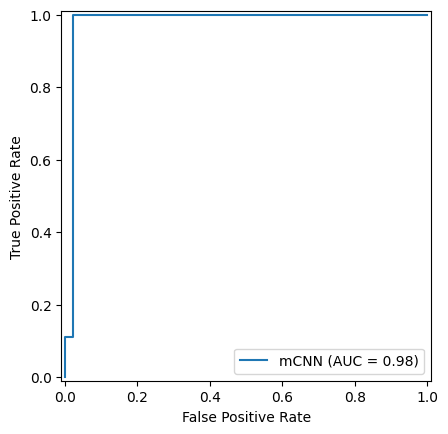

In [11]:
if VALIDATION_MODE == "independent":
    generator = DataGenerator(x_train, y_train, batch_size=BATCH_SIZE)
    
    model = DeepScan(
        num_filters=NUM_FILTER,
        num_hidden=NUM_HIDDEN,
        window_sizes=WINDOW_SIZES
    )
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.build(input_shape=x_train.shape)
    model.summary()
    
    # Train the model
    model.fit(
        generator,
        epochs=EPOCHS,
        shuffle=True,
    )
    
        
    TP, FP, TN, FN, Sens, Spec, Acc, MCC, AUC, F1 = model_test(model, x_test, y_test)